## Heart Stroke Prediction

### 0. Summary

#### Goal

Forecast the likelihood of a patient experiencing a stroke as a function of:
 - presence of diseases,
 - age,
 - gender,
 - smoking status,
 - etc.

#### Dataset

The data is a standard text file consisting of comma separated values, found in various places (for example [here](https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset)), with the following features:
 1. gender (object)
 2. age (float)
 3. hypertension (int)
 4. heart_disease (int)
 5. ever_married (object)
 6. work_type (object)
 7. Residence_type (object)
 8. avg_glucose (float)
 9. bmi (float)
 10. smoking_status (object)
 11. stroke (int)

There is a total of 5110 records.

#### Methods

Four methods will be used in attempting to forecast heart strokes:
 1. Logistic Regression
 2. Support Vector Machines
 3. Decision Tree Classifiers
 4. K-Nearest Neighbors

---
### 6. Feature Engineering

#### Preprocess data for feature selection and feature engineering

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as tck
import pandas as pd
import seaborn as sns
import sklearn as skl
import statsmodels.api as smapi
import statsmodels as sms
import scipy as scp
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

In [2]:
def plot_kde(
        df_input: pd.DataFrame,
        grid_len: int,
        lim_x: list[int],
        lim_y: list[int],
        data_spread: list[float],
        lbl_mean: list[float],
        lbl_median: list[float],
        title: str,
        ylabl: str,
        xlabl: str,
    ):
    # -------------------------------------------------------------------------
    data_kde = df_input.to_numpy()
    grid_kde = np.linspace(lim_x[0], lim_x[1], grid_len)
    dens_kde = scp.stats.gaussian_kde(data_kde)(grid_kde)
    val_mean = np.mean(data_kde)
    val_medn = np.median(data_kde)
    # -------------------------------------------------------------------------
    fig, axs = plt.subplots(figsize=(6,3))
    axs.plot(
        grid_kde,
        dens_kde,
        color='blue',
        lw=1,
        linestyle='-'
    )
    axs.plot(
        data_kde,
        data_spread[0] + data_spread[1] * np.random.random(data_kde.shape[0]),
        '.',
        color='darkgray',
        alpha=0.1
    )
    axs.axvline(
        ymin=0.000,
        ymax=1.000,
        x=np.mean(data_kde),
        lw=0.5,
        color='red',
        label='mean'
    )
    axs.axvline(
        ymin=0.000,
        ymax=1.00,
        x=np.median(data_kde),
        lw=0.5,
        color='blue',
        label='mean'
    )
    axs.tick_params(
        axis='both',
        direction='in',
        top=True,
        right=True
    )
    axs.set_ylim(
        lim_y[0],
        lim_y[1]
    )
    axs.set_ylabel(ylabl)
    axs.set_xlabel(xlabl)
    axs.set_title(title)
    axs.text(
        val_mean+lbl_mean[0],
        lbl_mean[1], 
        f'mean={val_mean:.1f}'
    )
    axs.text(
        val_medn+lbl_median[0],
        lbl_median[1],
        f'median={val_medn:.1f}'
    )
    fig.tight_layout()
    return

In [4]:
# 0. read the dataframe
df_orig = pd.read_csv("heart_stroke_prediction.csv")
df_orig.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


In [5]:
# 1. drop id column, save it for later
df_id = df_orig['id'].copy()
del df_orig['id']
df_orig.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             5110 non-null   object 
 1   age                5110 non-null   float64
 2   hypertension       5110 non-null   int64  
 3   heart_disease      5110 non-null   int64  
 4   ever_married       5110 non-null   object 
 5   work_type          5110 non-null   object 
 6   Residence_type     5110 non-null   object 
 7   avg_glucose_level  5110 non-null   float64
 8   bmi                4909 non-null   float64
 9   smoking_status     5110 non-null   object 
 10  stroke             5110 non-null   int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 439.3+ KB


In [6]:
# 2. inspect unique values in each categorical feature
for col in df_orig.columns:
    if df_orig[col].dtype == 'object':
        print(df_orig[col].unique())

['Male' 'Female' 'Other']
['Yes' 'No']
['Private' 'Self-employed' 'Govt_job' 'children' 'Never_worked']
['Urban' 'Rural']
['formerly smoked' 'never smoked' 'smokes' 'Unknown']


In [7]:
# 3. replace spaces and dashes with underscores
for col in df_orig.columns:
    if df_orig[col].dtype == 'object':
        df_orig[col] = df_orig[col].str.replace('-','_')
        df_orig[col] = df_orig[col].str.replace(' ','_')

In [8]:
# 4. turn all string-typed categorical values to lower-case
for col in df_orig.columns:
    if df_orig[col].dtype == 'object':
        df_orig[col] = df_orig[col].map(lambda x:x.lower())

In [9]:
# 5. change all column titles to lower case
df_orig.columns = df_orig.columns.str.lower()

In [10]:
# 6. take a look at some details.
df_orig.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             5110 non-null   object 
 1   age                5110 non-null   float64
 2   hypertension       5110 non-null   int64  
 3   heart_disease      5110 non-null   int64  
 4   ever_married       5110 non-null   object 
 5   work_type          5110 non-null   object 
 6   residence_type     5110 non-null   object 
 7   avg_glucose_level  5110 non-null   float64
 8   bmi                4909 non-null   float64
 9   smoking_status     5110 non-null   object 
 10  stroke             5110 non-null   int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 439.3+ KB


The numerical `bmi` feature is missing about 4% of the values. These will be imputed at a later step.

In [11]:
# 7. look for isna values
for col in df_orig.columns:
    print(df_orig[col].isna().sum(),df_orig[col].isnull().sum())

0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
201 201
0 0
0 0


This confirms the output of the previous `df.info()` step

In [12]:
# 8. rename all columns to 3 letters - messy looking code wastes time. Don't change 'stroke'
df_orig = df_orig.rename(columns={
        'gender'           :'gen',
        'hypertension'     :'hyp',
        'heart_disease'    :'htd',
        'ever_married'     :'evm',
        'work_type'        :'wtp',
        'residence_type'   :'rtp',
        'avg_glucose_level':'agl',
        'smoking_status'   :'sms',
    }   
)

In [13]:
df_orig

,gen,age,hyp,htd,evm,wtp,rtp,agl,bmi,sms,stroke
0,male,67.0,0,1,yes,private,urban,228.69,36.6,formerly_smoked,1
1,female,61.0,0,0,yes,self_employed,rural,202.21,NaN,never_smoked,1
2,male,80.0,0,1,yes,private,rural,105.92,32.5,never_smoked,1
3,female,49.0,0,0,yes,private,urban,171.23,34.4,smokes,1
4,female,79.0,1,0,yes,self_employed,rural,174.12,24.0,never_smoked,1
...,...,...,...,...,...,...,...,...,...,...,...
5105,female,80.0,1,0,yes,private,urban,83.75,NaN,never_smoked,0
5106,female,81.0,0,0,yes,self_employed,urban,125.20,40.0,never_smoked,0
5107,female,35.0,0,0,yes,self_employed,rural,82.99,30.6,never_smoked,0
5108,male,51.0,0,0,yes,private,rural,166.29,25.6,formerly_smoked,0


#### Use K-Nearest Neighbors to impute the missing `bmi` values

In [14]:
# 1. section out the different types found in the dataframe
feat_obj = list(df_orig.select_dtypes(include='object' ).columns)
feat_int = list(df_orig.select_dtypes(include='int64'  ).columns); feat_int.remove('stroke')
feat_flt = list(df_orig.select_dtypes(include='float64').columns)
feat_tgt = 'stroke'

In [15]:
# 3. label-encode categorical (object) columns
encoders = {}
df_prep  = pd.DataFrame()
for col in feat_obj:
    encoders[col] = skl.preprocessing.LabelEncoder()
    curr_data = df_orig[col][df_orig[col].notnull()].values.reshape(-1,1)
    encoders[col].fit(curr_data)
    df_prep[col] = encoders[col].transform(curr_data).flatten()

In [16]:
# 4. add the rest of the features to df_work, convert everything to floats
df_prep = pd.concat([df_prep, df_orig[feat_int],df_orig[feat_flt],df_orig[feat_tgt]],axis=1,join='outer')

In [17]:
# 5. impute NaN values via KNN - all ints cast as floats here
df_impt = pd.DataFrame(
    skl.impute.KNNImputer(n_neighbors=11).fit_transform(df_prep),
    columns=df_prep.columns
)

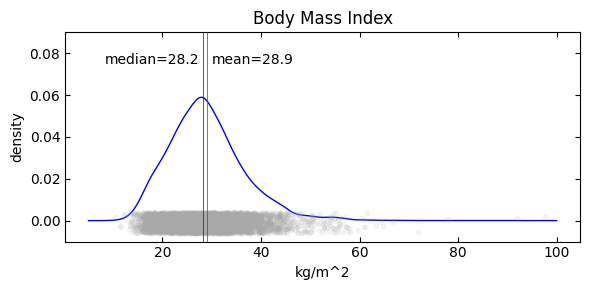

In [18]:
# 6. look at the result
plot_kde(df_impt['bmi'],1000,[ 5,100],[-0.010,0.09],[-0.006,0.0100],[1,0.075],[-20,0.075],'Body Mass Index','density','kg/m^2')

In [19]:
# 7. change obj & int features back to int64. rename column
df_impt[feat_obj+feat_int] = df_impt[feat_obj+feat_int].astype(int)

In [21]:
# 8. decode the imputed columns back to their original categories
for key, val in encoders.items():
    reshaped_col = df_impt[key].values.reshape(-1,1)
    df_impt[key] = encoders[key].inverse_transform(reshaped_col).flatten()

#### One-Hot Encode Categorical Features

In [22]:
# One-Hot encode all the categorical types
encoder_onehot = skl.preprocessing.OneHotEncoder(sparse_output=False)
data_encd = encoder_onehot.fit_transform(df_impt[feat_obj]) # encoder is saved for later.
df_encd = pd.DataFrame(data_encd,columns=encoder_onehot.get_feature_names_out())

#### Generate Numerical Features

In [24]:
def feature_numerical(
        data_col: pd.DataFrame(),
        transforms: list[str],
    ):
    data_transformed = []
    for xfr in transforms:
        if xfr == 'logexp':
            data = np.log(data_col)
            data.name = data_col.name + '_logexp'
            data_transformed.append(data)
        elif xfr == 'logten':
            data = np.log10(data_col)
            data.name = data_col.name + '_logten'
            data_transformed.append(data)
        elif xfr == 'boxcox':
            data = pd.Series(scp.stats.boxcox(data_col)[0])
            data.name = data_col.name + '_boxcox'
            data_transformed.append(data)
        elif xfr == 'yeojon':
            data = pd.Series(scp.stats.yeojohnson(data_col)[0])
            data.name = data_col.name + '_yeojon'
            data_transformed.append(data)
        elif xfr == 'power2':
            data = np.power(data_col,2)
            data.name = data_col.name + '_power2'
            data_transformed.append(data)
        elif xfr == 'power3':
            data = np.power(data_col,3)
            data.name = data_col.name + '_power3'
            data_transformed.append(data)
    dataframe = pd.concat(data_transformed, axis=1)
    return dataframe

In [25]:
# generate numerical features - add to these if needed (these should be enough)
transformations = ['logexp','logten','boxcox','yeojon','power2','power3']
df_flts = pd.DataFrame() # "dataframe floats"
df_flts = pd.concat([
        df_flts,
        feature_numerical(df_impt['bmi'],transformations),
        feature_numerical(df_impt['age'],transformations),
        feature_numerical(df_impt['agl'],transformations),
    ],
    axis=1,
    join='outer'
)

In [49]:
# Apply Robust Scaling - best overall performance for irregularly shaped distros
df_scld = pd.DataFrame()
for col in df_flts:
    temp_col = df_flts[col].values.reshape(-1, 1)
    df_scld[col] = skl.preprocessing.RobustScaler().fit_transform(temp_col).flatten()

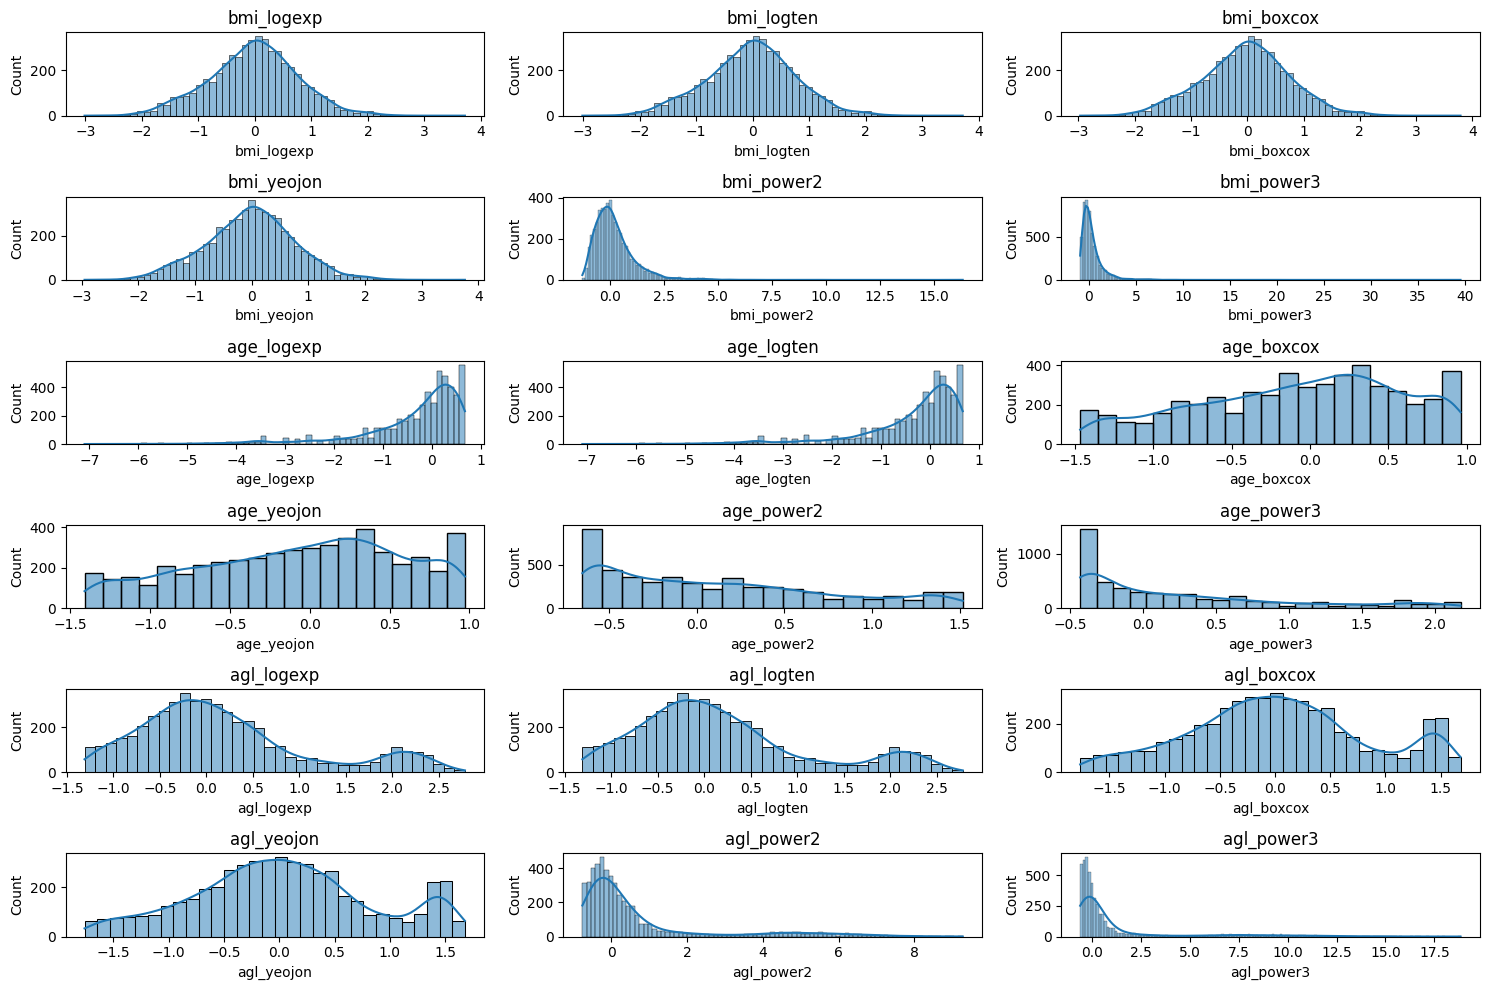

In [55]:
# plot a 6x3 grid of seaborn histograms of all the rescaled features
fig, axes = plt.subplots(nrows=6, ncols=3, figsize=(15, 10))
axes = axes.flatten()
for i, col in enumerate(df_scld.columns):
    sns.histplot(df_scld[col], kde=True, ax=axes[i])
    axes[i].set_title(col)
plt.tight_layout()
plt.show()
